# Visualising the pulsar data

You can use this notebook to visualise the frequency vs phase data you recorded from the telescope.

## Using the notebook

You can write python code in the cells. Execute the code with Ctrl-Enter. The results are displayed below the cell.

Cells can also contain annotations like this one. A cell can be toggled between code and "[markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)" in the drop-down menu above. The annotation cells can be written in plain text, but also support markdown formatting, a cheat-sheet for which can be found at the above link. Double-click to edit the text, and Ctrl-Enter return to the formated version. Try it on this comment.

## Load the required libraries

We mainly make use of two libraries in this template: Numpy and matplotlib. You may be familiar with these from other courses.

Numpy provides routines for doing lots of math stuff. For example, here we use the numpy.loadtxt routine to read a text file and convert the characters to numbers with just a single line of code. Here we import the numpy library with a short name `np` 

We will import the matplotlib package as `plt` in order to use it to make all kinds of plots.

Numpy (and the related scipy) have very powerful tools for doing all kinds of operations, including fitting functions to data. You can find lots of information on these methods if you search around the web and in the numpy manual, and do talk to your demonstrator.

We don't need all these just for plotting, but some e.g. astropy might be very useful for other tasks.


In [45]:
# To begin, we import some libraries that we will need later.

# The numpy library will allow us to do FFTs
import numpy as np

# The pyplot module from matplotlib will allow us to plot things.
from  matplotlib import pyplot as plt

# pi is a useful value!
from math import pi

import os

## Connect to your google drive to allow you to read data files

In [46]:
import numpy as np

filepath = "/Users/alismk/Desktop/3rdYear Courses/Sem2/Lab/20260203_162736_B1933+16.npz"

data = np.load(filepath, allow_pickle=True)

print(data.files)   # shows what's inside the npz
print(data['times'])

['times', 'freqs', 'cfreq', 'bw', 'data', 'approx_period', 'header', 'source_name']
[61074.68714715 61074.68934775 61074.69166876 61074.69397731
 61074.69559662]


## Read the file and make a plot

We will use the psrchive software to load the data. The provided `load_channels()` method will read the data into a `numpy` array.

In [47]:
import os
import numpy as np

# Path to your lab folder
basepath = "/Users/alismk/Desktop/3rdYear Courses/Sem2/Lab"

# Your actual data file
filename = os.path.join(basepath, "20260217_095751_B1933+16.npz")

# Load the npz file
obsdata = np.load(filename, allow_pickle=True)

# Inspect header
print(obsdata["header"])
print("")

# Extract data array
data = obsdata["data"]
print("Data array shape:", data.shape)

Filename                      : 20260217_095751_B1933+16.ar
Source Name                   : B1933+16
Number of channels            : 40
Number of phase bins          : 1024
Number of sub-integrations    : 9
Centre Freq (MHz)             : 611.0
Bandwidth (MHz)               : 10.0
Integration Time (s)          : 1780.0
Telescope                     : Jodrell

Data array shape: (9, 40, 1024)


### Plotting

We have read a 2-d `numpy` array which we can then plot using `matplotlib`.


The code then plots a 2-d plot showing intensity as a function of frequency and phase. This is the **phase vs frequency** plot. We can also integrate over frequency by summing along the first axis of the array. This produces **intensity vs phase** plot.

Check you understand what you are seeing in these plots. Discuss them with your demonstrator.

Nsub = 9 Nchan = 40 Nphase= 1024


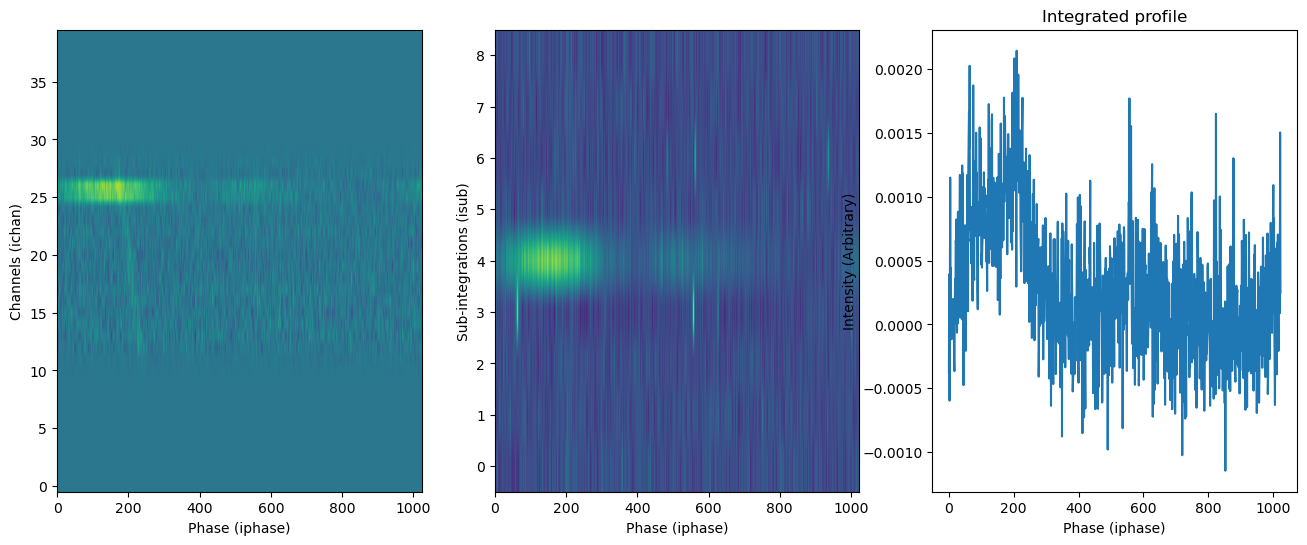

In [48]:
# Here we infer the number of channels and numnber of phase bins based on the last entry in the file.
nsub, nchan,nphase = data.shape

# Print this out for verification
print("Nsub = {} Nchan = {} Nphase= {}".format(nsub, nchan,nphase))
        

# Here is where we reshape the 1-d array into a 2-d data structure
iphase=np.arange(nphase)
ichan=np.arange(nchan)
isub = np.arange(nsub)

# We can integrate over all frequency channels by using the `sum` routine from numpy...
fully_averaged=np.mean(data,axis=(0,1))
time_averaged = np.mean(data,axis=0)
freq_averaged = np.mean(data,axis=1)

# Plot the 2-d data:
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(time_averaged,aspect='auto',origin='lower')
plt.xlabel("Phase (iphase)")
plt.ylabel("Channels (ichan)")

plt.subplot(132)
plt.imshow(freq_averaged,aspect='auto',origin='lower')
plt.xlabel("Phase (iphase)")
plt.ylabel("Sub-integrations (isub)")

# Plot the integrated profile:
plt.subplot(133)
plt.plot(fully_averaged)
plt.xlabel("Phase (iphase)")
plt.ylabel("Intensity (Arbitrary)")
plt.title("Integrated profile")
plt.show()

## Dispersion

The pulsar signal experiences a frequency dependent delay caused by the interstellar plasma. This should be visiable in the frequency vs phase plot as a drift in the pulse as a function of frequency. This is called dispersion.

In order to measure and correct for the dispersion, you will need to convert the axes of your data to physical units.

The frequency axis can be determined from the central frequency and bandwidth of your instrument
The time axis can be determined from the period of the pulsar and the number of phase bins.


### De-dispersion
Correcting for the dispersion requires shifting the rows of your 2-d array by a frequency dependent time delay equal to the negative of the dispersion induced delay. This process is called "de-dispersion". Once de-dispersed, integrating over frequency channels should give improved signal-to-noise and a narrower pulse.

To get you started, we have provided a function `shift_rows` which will rotate each row of a 2-d matrix by the number of bins specified in the `shifts` array.

The demo program will use this to shift each row by an arbitrary amount, you will need to modify the program to shift by the time delay caused by a given "dispersion measure" (DM). Read the lab script for more information about how to compute this time delay.

Modify this program to correct the data for a given DM. Try a few values of DM (see if you can find common values for dispersion measure of pulsars) and see if you can roughly detrmine the value that maximises the DM. Check with your demonstrator if your DM value is sensible. You should extend your program to try to determine the DM in a more rigourous way. There are many ways to do this, if you are stuck, discuss with your demonstrator.

In [49]:

def shift_rows(data_in, shifts):
    shifted = np.zeros_like(data_in)
    if data_in.ndim == 3:
        for sub in range(nsub):
            shifted[sub] = shift_rows(data_in[sub],shifts)
    else:
        for chan in range(nchan):
            shifted[chan] = np.roll(data_in[chan],int(shifts[chan]))
    return shifted



In [50]:
import numpy as np
import matplotlib.pyplot as plt

data = obsdata["data"]      
freqs = obsdata["freqs"]
P = float(obsdata["approx_period"])  

print("data shape:", data.shape)
print("freqs shape:", freqs.shape)
print("Period (s):", P)


time_averaged = np.mean(data, axis=0)
nchan, nphase = time_averaged.shape
print("time_averaged shape:", time_averaged.shape)

data shape: (9, 40, 1024)
freqs shape: (40,)
Period (s): 0.358722178
time_averaged shape: (40, 1024)


In [51]:
K_DM = 4.148808e3  # seconds * MHz^2 * (pc cm^-3)^-1

def dm_to_bin_shifts(dm, freqs_mhz, P_sec, nphase, nu_ref_mhz=None):
    freqs_mhz = np.asarray(freqs_mhz, dtype=float)
    if nu_ref_mhz is None:
        nu_ref_mhz = float(np.max(freqs_mhz))

    # delay in SECONDS (relative to nu_ref)
    dt_s = K_DM * dm * (freqs_mhz**(-2) - nu_ref_mhz**(-2))

    # convert delay -> phase bins
    bins = (dt_s / P_sec) * nphase

    # remove the delay
    return -bins

In [52]:
def dedisperse_at_dm(dm):
    shifts = dm_to_bin_shifts(dm, freqs, P, nphase)
    ded = shift_rows(time_averaged, shifts)      
    prof = np.sum(ded, axis=0)                   
    return ded, prof


In [53]:
# ============================================================
# USER SETTINGS  (change these only)
# ============================================================

DM_MIN = 0
DM_MAX = 300        # ← change this to set the biggest DM to search

COARSE_STEP = 1
MEDIUM_STEP = 0.5
FINE_STEP = 0.09
ULTRA_STEP = 0.001

MEDIUM_HALF_WIDTH = 10   # search ±10 around best coarse DM
FINE_HALF_WIDTH = 2      # search ±2 around best medium DM
ULTRA_HALF_WIDTH = 0.5   # search ±0.5 around best fine DM

# Skip DM ranges (inclusive). Example: skip 40–80 and 120–130
SKIP_RANGES = []


--- COARSE SEARCH ---
Range: 0 to 300 step 1
Best coarse DM: 163.0

--- MEDIUM SEARCH ---
Range: 153.0 to 173.0
Best medium DM: 163.0

--- FINE SEARCH ---
Range: 161.07000000000008 to 165.07000000000008
Best fine DM: 163.07000000000008

--- ULTRA-FINE SEARCH ---
Range: 162.5570000000024 to 163.5570000000024
Best ultra-fine DM: 163.0570000000024


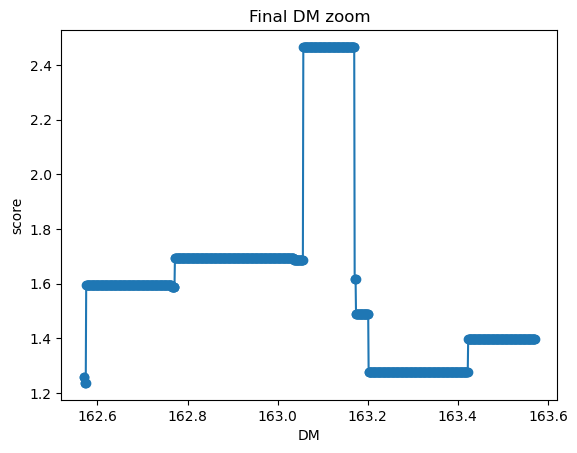


FINAL DM = 163.0570000000024


In [54]:
def dm_score(ded, prof):
    """
    Robust DM score:
      - SNR: (peak - baseline)/noise
      - channel support: how many channels are significantly 'on' at the peak phase
      - sharpness penalty: divide by pulse width above a threshold
    Returns a single scalar score (higher is better).
    """
    baseline = np.median(prof)
    noise = np.std(prof)
    if noise == 0:
        return 0.0

    snr = (np.max(prof) - baseline) / noise
    peak = int(np.argmax(prof))

    # Channel-coherence check at the pulse peak phase bin
    channel_values = ded[:, peak]
    ded_med = np.median(ded)
    ded_std = np.std(ded)
    if ded_std == 0:
        return 0.0
    chan_strength = np.sum(channel_values > (ded_med + 2 * ded_std))

    # Pulse width in phase bins (penalise smearing)
    width = np.sum(prof > (baseline + 2 * noise))
    if width == 0:
        return 0.0

    return snr * chan_strength / width

def scan_dm_grid(dms):
    """
    Scan a list/array of DMs and return (best_dm, best_score, scores_array).
    """
    dms = np.asarray(dms, dtype=float)
    scores = np.zeros_like(dms, dtype=float)

    for i, dm in enumerate(dms):
        ded, prof = dedisperse_at_dm(dm)
        scores[i] = dm_score(ded, prof)

    best_i = int(np.argmax(scores))
    return float(dms[best_i]), float(scores[best_i]), scores



def remove_skipped_ranges(dms, skip_ranges):
    """
    Remove DM values that fall inside any excluded interval.
    skip_ranges = [(min1,max1), (min2,max2), ...]
    """
    dms = np.asarray(dms, dtype=float)

    if not skip_ranges:
        return dms

    mask = np.ones_like(dms, dtype=bool)

    for lo, hi in skip_ranges:
        mask &= ~((dms >= lo) & (dms <= hi))

    return dms[mask]


def scan_dm_range(dms):

    dms = remove_skipped_ranges(dms, SKIP_RANGES)

    if len(dms) == 0:
        raise ValueError("All DM values were removed by SKIP_RANGES.")

    scores = []

    for dm in dms:
        ded, prof = dedisperse_at_dm(dm)
        scores.append(dm_score(ded, prof))

    scores = np.array(scores)
    best_index = np.argmax(scores)

    return dms[best_index], scores


def hierarchical_dm_search():

    print("\n--- COARSE SEARCH ---")
    dms = np.arange(DM_MIN, DM_MAX+COARSE_STEP, COARSE_STEP)
    best_dm, scores = scan_dm_range(dms)
    print("Range:", DM_MIN, "to", DM_MAX, "step", COARSE_STEP)
    print("Best coarse DM:", best_dm)


    print("\n--- MEDIUM SEARCH ---")
    dms = np.arange(best_dm-MEDIUM_HALF_WIDTH,
                    best_dm+MEDIUM_HALF_WIDTH+MEDIUM_STEP,
                    MEDIUM_STEP)
    best_dm, scores = scan_dm_range(dms)
    print("Range:", best_dm-MEDIUM_HALF_WIDTH, "to", best_dm+MEDIUM_HALF_WIDTH)
    print("Best medium DM:", best_dm)


    print("\n--- FINE SEARCH ---")
    dms = np.arange(best_dm-FINE_HALF_WIDTH,
                    best_dm+FINE_HALF_WIDTH+FINE_STEP,
                    FINE_STEP)
    best_dm, scores = scan_dm_range(dms)
    print("Range:", best_dm-FINE_HALF_WIDTH, "to", best_dm+FINE_HALF_WIDTH)
    print("Best fine DM:", best_dm)


    print("\n--- ULTRA-FINE SEARCH ---")
    dms = np.arange(best_dm-ULTRA_HALF_WIDTH,
                    best_dm+ULTRA_HALF_WIDTH+ULTRA_STEP,
                    ULTRA_STEP)
    best_dm, scores = scan_dm_range(dms)
    print("Range:", best_dm-ULTRA_HALF_WIDTH, "to", best_dm+ULTRA_HALF_WIDTH)
    print("Best ultra-fine DM:", best_dm)


    # Plot final zoom
    plt.plot(dms, scores, marker='o')
    plt.xlabel("DM")
    plt.ylabel("score")
    plt.title("Final DM zoom")
    plt.show()

    return best_dm


# ============================================================
# RUN SEARCH
# ============================================================

best_dm = hierarchical_dm_search()
print("\nFINAL DM =", best_dm)

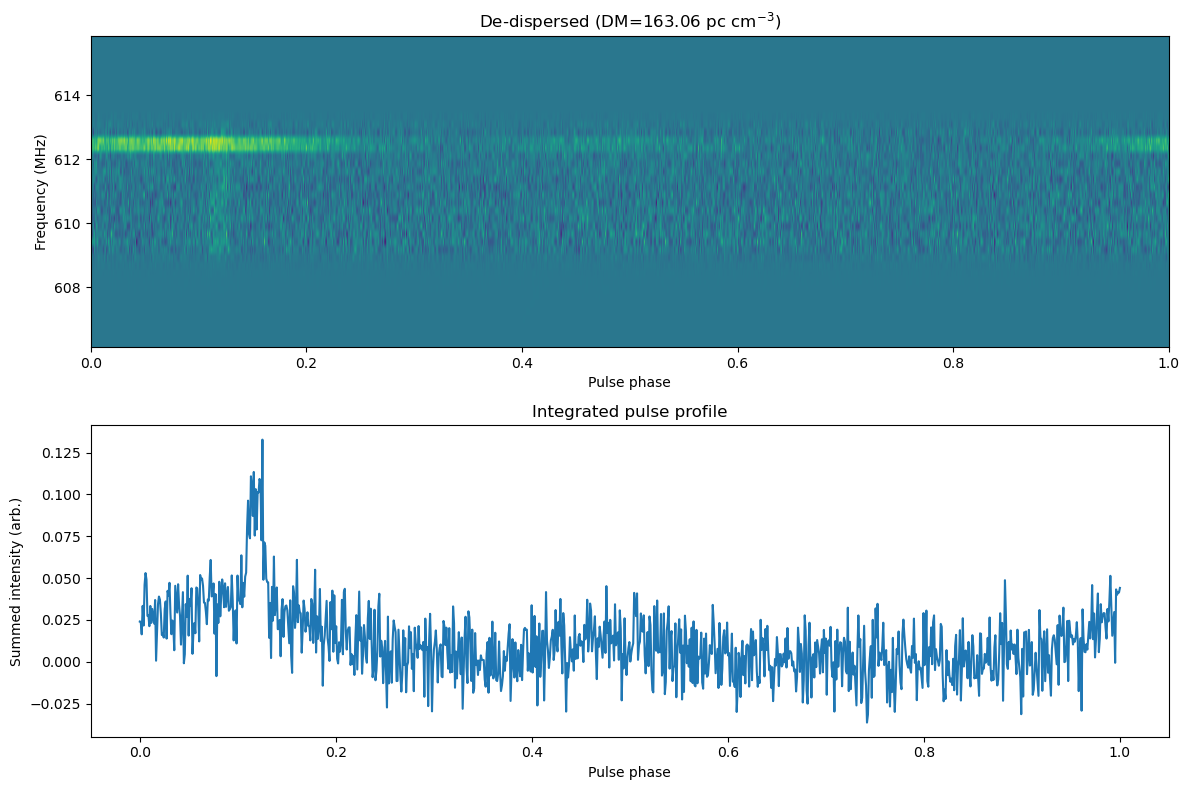

In [55]:

ded, prof = dedisperse_at_dm(best_dm)

phase = np.linspace(0, 1, nphase)

plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.imshow(ded, aspect="auto", origin="lower",
           extent=(0, 1, freqs[0], freqs[-1]))
plt.xlabel("Pulse phase")
plt.ylabel("Frequency (MHz)")
plt.title(f"De-dispersed (DM={best_dm:.2f} pc cm$^{{-3}}$)")

plt.subplot(212)
plt.plot(phase, prof)
plt.xlabel("Pulse phase")
plt.ylabel("Summed intensity (arb.)")
plt.title("Integrated pulse profile")

plt.tight_layout()
plt.show()

In [56]:
sh = dm_to_bin_shifts(150, freqs, P, nphase)
print("max |shift| bins:", np.max(np.abs(sh)))
print("unique int shifts (first 10):", np.unique(sh.astype(int))[:10])

max |shift| bins: 151.88769854790215
unique int shifts (first 10): [-151 -147 -143 -139 -135 -132 -128 -124 -120 -116]


Best DM from grid: 20.4


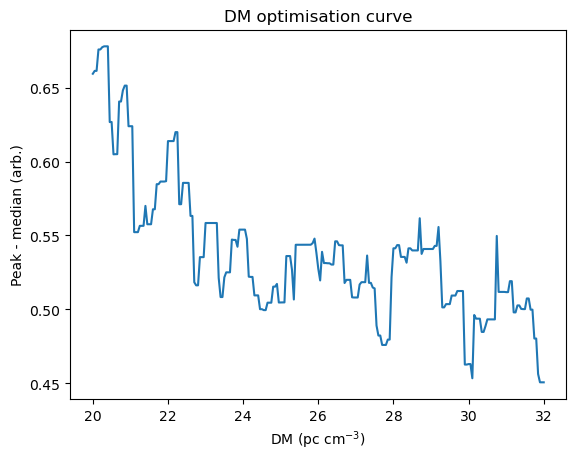

In [12]:
dm_grid = np.linspace(20, 32, 241)  # step 0.05
grid_scores = []

for dm in dm_grid:
    _, prof = dedisperse_at_dm(dm)
    grid_scores.append(np.max(prof) - np.median(prof))

best_dm = dm_grid[int(np.argmax(grid_scores))]
print("Best DM from grid:", best_dm)

plt.figure()
plt.plot(dm_grid, grid_scores)
plt.xlabel("DM (pc cm$^{-3}$)")
plt.ylabel("Peak - median (arb.)")
plt.title("DM optimisation curve")
plt.show()

In [180]:
sh = dm_to_bin_shifts(150, freqs, P, nphase)
print("shift bins min/max:", sh.min(), sh.max())
print("max |shift|:", np.max(np.abs(sh)))
print("unique int shifts:", np.unique(sh.astype(int)))

shift bins min/max: -151.88770193520767 -0.0
max |shift|: 151.88770193520767
unique int shifts: [-151 -147 -143 -139 -135 -132 -128 -124 -120 -116 -112 -108 -104 -100
  -96  -92  -88  -84  -80  -76  -73  -69  -65  -61  -57  -53  -49  -45
  -42  -38  -34  -30  -26  -22  -19  -15  -11   -7   -3    0]


In [181]:
print(obsdata["header"])

Filename                      : 20260203_122123_B1933+16.ar
Source Name                   : B1933+16
Number of channels            : 40
Number of phase bins          : 1024
Number of sub-integrations    : 1
Centre Freq (MHz)             : 611.0
Bandwidth (MHz)               : 10.0
Integration Time (s)          : 109.999188
Telescope                     : Jodrell


In [182]:
print("time_averaged shape:", time_averaged.shape)

time_averaged shape: (40, 1024)


In [183]:
np.max(prof) - np.median(prof)

0.2528654

In [184]:
K = 4.148808e3  # ms
DM = 150
dt_ms = K * DM * (freqs.min()**-2 - freqs.max()**-2)


bin_ms = (P / nphase) * 1000
print("Delay in bins:", dt_ms / bin_ms)

Delay in bins: 0.15188770193520765


In [185]:
print(freqs.min(), freqs.max())

606.125 615.875


In [186]:
print("freq min:", freqs.min())
print("freq max:", freqs.max())
print("bandwidth:", freqs.max()-freqs.min())

freq min: 606.125
freq max: 615.875
bandwidth: 9.75
